Enter the company's ticker name: AAPL


[*********************100%%**********************]  1 of 1 completed


Downloaded data for AAPL
Epoch 1/20
7/7 [==============================] - 5s 69ms/step - loss: 0.1505
Epoch 2/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0435
Epoch 3/20
7/7 [==============================] - 0s 40ms/step - loss: 0.0352
Epoch 4/20
7/7 [==============================] - 0s 43ms/step - loss: 0.0290
Epoch 5/20
7/7 [==============================] - 0s 41ms/step - loss: 0.0267
Epoch 6/20
7/7 [==============================] - 0s 40ms/step - loss: 0.0271
Epoch 7/20
7/7 [==============================] - 0s 43ms/step - loss: 0.0248
Epoch 8/20
7/7 [==============================] - 0s 43ms/step - loss: 0.0238
Epoch 9/20
7/7 [==============================] - 0s 39ms/step - loss: 0.0237
Epoch 10/20
7/7 [==============================] - 0s 41ms/step - loss: 0.0210
Epoch 11/20
7/7 [==============================] - 0s 44ms/step - loss: 0.0188
Epoch 12/20
7/7 [==============================] - 0s 43ms/step - loss: 0.0219
Epoch 13/20
7/7 [===================

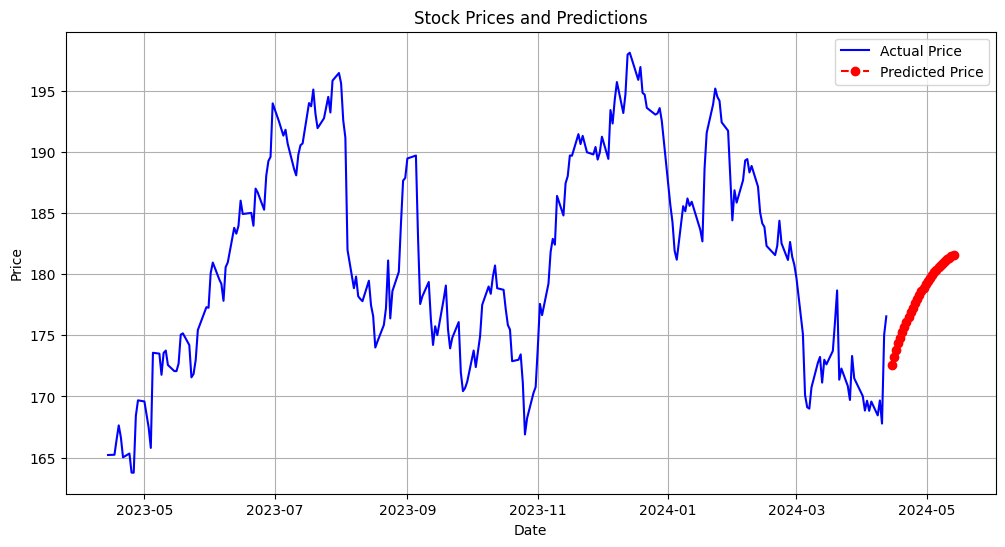

Predicted closing prices for the next 30 days:
Day 1: 172.6094512939453 - 2024-04-14
Day 2: 173.25376892089844 - 2024-04-15
Day 3: 173.8179931640625 - 2024-04-16
Day 4: 174.3296661376953 - 2024-04-17
Day 5: 174.8057098388672 - 2024-04-18
Day 6: 175.2562255859375 - 2024-04-19
Day 7: 175.68716430664062 - 2024-04-20
Day 8: 176.10165405273438 - 2024-04-21
Day 9: 176.50112915039062 - 2024-04-22
Day 10: 176.88633728027344 - 2024-04-23
Day 11: 177.25733947753906 - 2024-04-24
Day 12: 177.61407470703125 - 2024-04-25
Day 13: 177.9564208984375 - 2024-04-26
Day 14: 178.28416442871094 - 2024-04-27
Day 15: 178.5970001220703 - 2024-04-28
Day 16: 178.894775390625 - 2024-04-29
Day 17: 179.17735290527344 - 2024-04-30
Day 18: 179.44473266601562 - 2024-05-01
Day 19: 179.6970672607422 - 2024-05-02
Day 20: 179.93460083007812 - 2024-05-03
Day 21: 180.1573944091797 - 2024-05-04
Day 22: 180.36578369140625 - 2024-05-05
Day 23: 180.56007385253906 - 2024-05-06
Day 24: 180.74053955078125 - 2024-05-07
Day 25: 180.9

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Function to download stock data
def download_stock_data(ticker, start_date, end_date):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        print(f"Downloaded data for {ticker}")
        return stock_data
    except Exception as e:
        print(f"Failed to download data for {ticker}: {str(e)}")
        return None

# Function to preprocess data
def preprocess_data(stock_data):
    data = stock_data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Function to prepare training data
def prepare_training_data(scaled_data, lookback=40):
    x_train, y_train = [], []
    for i in range(lookback, len(scaled_data)):
        x_train.append(scaled_data[i-lookback:i, 0])
        y_train.append(scaled_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train LSTM model
def train_lstm_model(x_train, y_train):
    model = create_lstm_model((x_train.shape[1], 1))
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    model.fit(x_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])
    return model

# Function to predict stock price for the next 30 days
def predict_stock_price(model, scaled_data, scaler, lookback=40, prediction_days=30):
    x_data = scaled_data[-lookback:].reshape(1, -1, 1)
    predictions = []
    dates = []
    for i in range(prediction_days):
        next_day_close = model.predict(x_data)
        predictions.append(next_day_close[0, 0])
        x_data = np.append(x_data[:, 1:], next_day_close).reshape(1, -1, 1)
        next_date = pd.Timestamp.now() + pd.Timedelta(days=i+1)
        dates.append(next_date)
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions, dates

# Main function
def main():
    ticker = input("Enter the company's ticker name: ")
    start_date = pd.Timestamp.now() - pd.Timedelta(days=365)  # 1 year of historical data
    end_date = pd.Timestamp.now() - pd.Timedelta(days=1)  # Yesterday's date

    # Download stock data
    stock_data = download_stock_data(ticker, start_date, end_date)
    if stock_data is None:
        return

    # Preprocess data
    scaled_data, scaler = preprocess_data(stock_data)

    # Prepare training data
    x_train, y_train = prepare_training_data(scaled_data)

    # Train LSTM model
    model = train_lstm_model(x_train, y_train)

    # Predict stock price for the next 30 days
    predictions, dates = predict_stock_price(model, scaled_data, scaler)

    # Visualize stock prices
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data['Close'], label='Actual Price', color='blue')
    plt.plot(dates, predictions, label='Predicted Price', color='red', linestyle='--', marker='o')
    plt.title("Stock Prices and Predictions")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print predicted closing prices for the next 30 days
    print("Predicted closing prices for the next 30 days:")
    for i, (price, date) in enumerate(zip(predictions, dates)):
        print(f"Day {i+1}: {price[0]} - {date.date()}")

if __name__ == "__main__":
    main()